<a href="https://colab.research.google.com/github/Ritu-01/Adni_Gradient-BoostedTrees_PatData/blob/main/Copy_of_Module_5b_Adni_PatData_cleaned_4SNPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the notebook where we will include data on 4 SNPs on chromosome 19.

This notebook was created at San Francisco State University for the PINC and gSTAR programs by Dr Pleuni Pennings, Lucy Moctezuma Tan and Lorena Benitez Rivera. We acknowledge help from Dr Adegoke Ojewole and Dr Hector Corrada Bravo.



## Loading libraries and data from Github repository

In [ ]:
# Importing packages for data handling
import pandas as pd
import numpy as np

# importing packages for making Random Forest Model and evaluating performance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score

# importing packages for ploting
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from plotnine import *

Load the "PatData_cleaned_4SNPs.csv" version of the dataset that has only 4 SNP locations on chromosome 19.

In [ ]:
# Loading data from github repository
url = "https://raw.githubusercontent.com/pleunipennings/CSC508Data/main/PatData_cleaned_4SNPs.csv"
data = pd.read_csv(url)
data.head()

,PTID,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,DX,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,rs4147929,rs41289512,rs76320948,rs3865444
0,002_S_0295,84.8,2,18,1,1,1,1,NL,43332.500000,6805.125000,1.071568e+06,3752.625000,17693.875000,19420.125000,1.649602e+06,1.000000,0.002014,0.0,0
1,002_S_0413,76.3,1,16,1,1,1,0,NL,31936.454545,6824.636364,1.055413e+06,4131.090909,20095.909091,20235.545455,1.600009e+06,1.003998,0.000000,0.0,1
2,002_S_0559,79.3,2,16,1,1,2,1,NL,38410.666667,7496.666667,1.092807e+06,3998.333333,18993.000000,22226.000000,1.703968e+06,2.000000,0.000000,0.0,1
3,002_S_0685,89.6,1,16,1,1,1,0,NL,40921.571429,7063.250000,9.800458e+05,3894.375000,14152.250000,18133.625000,1.521331e+06,1.000000,0.000000,0.0,0
4,002_S_0729,65.1,1,16,1,1,1,1,Dementia,23871.666667,5552.833333,8.942806e+05,2057.428571,16579.142857,16136.714286,1.298887e+06,2.000000,NaN,0.0,1


## Dropping Missing values

As mentioned before we have new features we have not used before, we will see if these will help improve our model's predictions for Alzheimers. Below we have a list of column names.

In [ ]:
# Loading column feature names
data.columns

Index(['PTID', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT',
       'PTMARRY', 'APOE4', 'DX', 'Ventricles', 'Hippocampus', 'WholeBrain',
       'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'rs4147929', 'rs41289512',
       'rs76320948', 'rs3865444'],
      dtype='object')

In [ ]:
# Check for missing data
data.isna().sum()

PTID            0
AGE             0
PTGENDER        0
PTEDUCAT        0
PTETHCAT        0
PTRACCAT        0
PTMARRY         0
APOE4           0
DX              0
Ventricles      0
Hippocampus     0
WholeBrain      0
Entorhinal      0
Fusiform        0
MidTemp         0
ICV             0
rs4147929      10
rs41289512     81
rs76320948     33
rs3865444       0
dtype: int64

In [ ]:
#Let's drop missing data present in the location features
data = data.dropna()
# Check how much data you have left
data.shape

(698, 20)

# Exploring Genetic Data ( APOE4 and SNPs Data)

## APOE4 Data

We have work with this mysterious feature before. But it is worth taking a closer look into it. The APOE4 gene has been associated with an increased risk of Alzheimer's disease. APOE4 has values for each patient that range from 0 to 2. We see here that 0 is most common, followed by 1 and then 2. When a patient has a 0 here, it means that the patient doesn’t carry the APOE4 allele, 1 means they carry one copy of APOE4 and 2 means they carry two copies.

## Task 1: plotting APOE4 frequencies.

- Create a barplot to check what percentage of people in this dataset carry both copies of this gene!

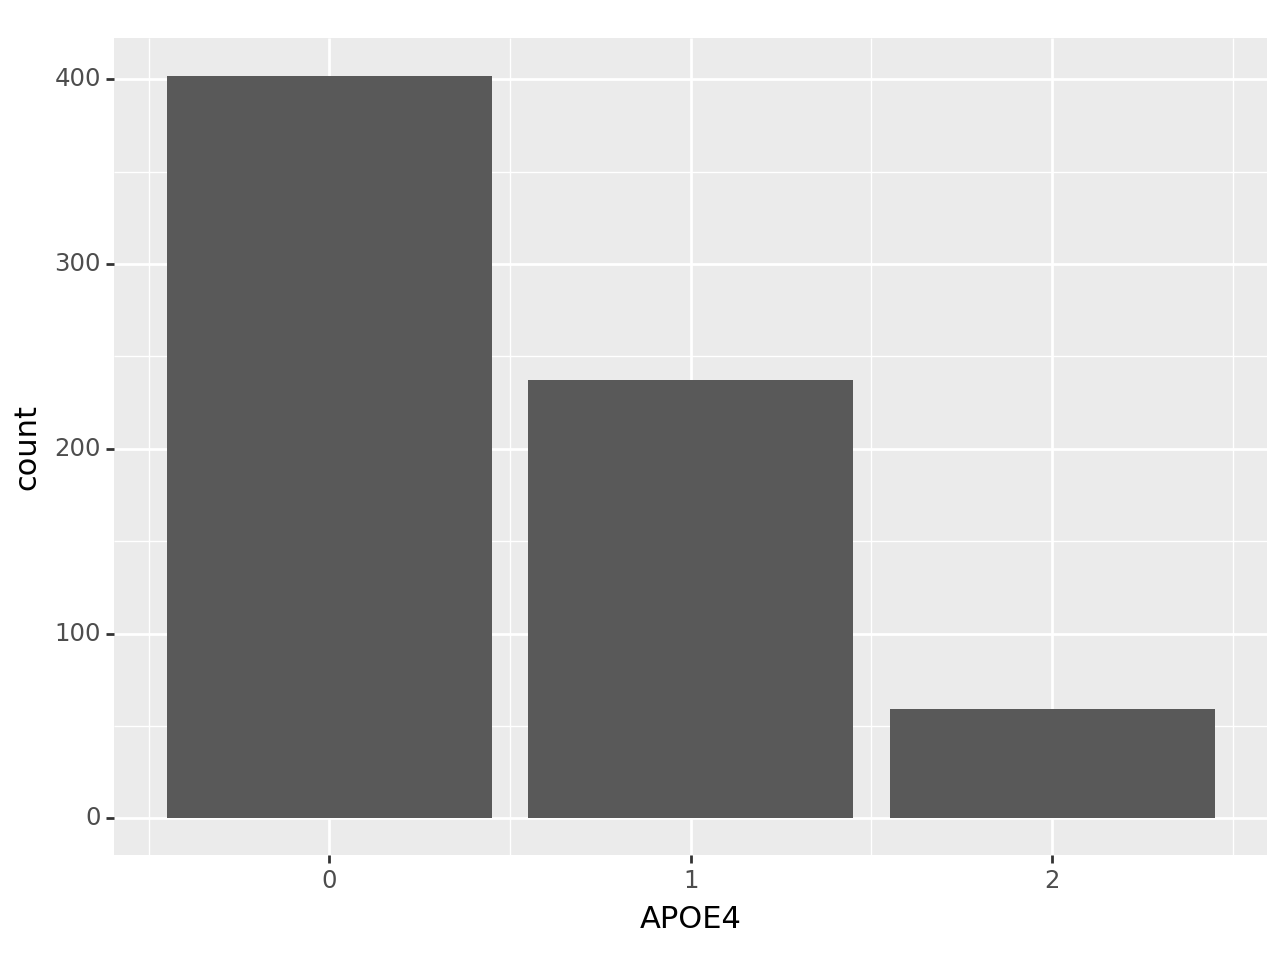

<Figure Size: (640 x 480)>

In [ ]:
# input your code here
(ggplot (data = data)+
 aes (x = 'APOE4')+
 geom_bar())

In [ ]:
data.groupby('APOE4').size() /len(data)

APOE4
0    0.575931
1    0.339542
2    0.084527
dtype: float64

## SNP Locations Data

Recall from the text that **SNP (Single Nucleotide Polymorphism)** are variants that consist of just one nucleotide in the same location. For our dataset we are considering 4 locations. These are:

- **rs4147929**
- **rs41289512**
- **rs76320948**
- **rs3865444**

These variables represent the location of SNP (snips) that we have interest in, essentially it is the equivalent of a genetic address. These are official names you can google to find more about each of these sites.

Normally, for each SNP, each chromosome can carry one genetic letter (A, C, G or T). Because we each have two copies of each of our chromosomes, we also have two letters for a SNP.

On a website called SNPedia, I looked up rs4147929. It tells me that we can have AA, AG or GG at this location. Carrying one or two A's at this location is associated with higher Alzheimer's risk.

Now, in the data we have, the letters are not listed, but instead a number is listed that we can interpret as the estimated number of G (non-risk) alleles in that person. If this number is close to 2, the person has genotype GG, if the number is close to 1, they have AG and if the number is close to 0, they have the AA genotype.

The reason that the numbers are not exactly 0, 1, and 2 has to do with how the data is collected.

https://www.snpedia.com/index.php/Rs4147929




In [ ]:
# Looking at values in location "rs4147929"

data["rs4147929"].value_counts()

2.000000    455
1.000000    180
0.000000     18
1.001007      3
1.997986      3
1.003998      3
1.996002      3
1.002991      3
1.981995      2
1.998993      2
1.002014      2
1.928009      1
1.042999      1
1.001984      1
1.009003      1
1.053986      1
1.019012      1
1.973999      1
1.092010      1
1.997009      1
1.005005      1
0.998993      1
1.026001      1
0.006012      1
1.031006      1
1.010010      1
0.996002      1
1.994995      1
1.949005      1
1.902008      1
0.001007      1
1.946014      1
1.993011      1
1.988007      1
0.011993      1
Name: rs4147929, dtype: int64

In [ ]:
# Let's round to have no decimals.
data["rs4147929"] = data["rs4147929"].round(decimals = 0)

In [ ]:
data["rs41289512"] = data["rs41289512"].round(decimals = 0)

In [ ]:
data["rs4147929"].value_counts()

2.0    474
1.0    203
0.0     21
Name: rs4147929, dtype: int64

Below is some terminoly for those who are not familiar with Genetic jargon!

- **Minor Frequency Alleles (MAF):** is the frequency at which the second most common allele in a population occur. They are important to study in population genetics because they provide information to distinguish comon versus rare variants in a population.

- **Homozygotes:**
The SNPs Minor Frequency Alleles are taken from Table 1 in this [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6836675/).
Each SNP comes in two letters (two alleles). The one that is less common is called the minor allele.

Note that for this SNP in location **rs4147929**, the Minor Allele Frequency is listed as 0.161. We therefore expect the square of that frequency to be the number of people who carry the allele 2x (homozygotes). In other words: if around 16% of all chromosome 19s in humans have an A at this location, then the chance that someone has two As is 16% of 16% = 2.6%. In our dataset, that would translate to just 18 people out of 698 people. Is this actually what the data shows?

$698* (0.161^2) = 18 \ people$.

As you can see in one of the previous cells, we have 21 peope in the dataset with two times the minor allele. That is pretty close to 18!

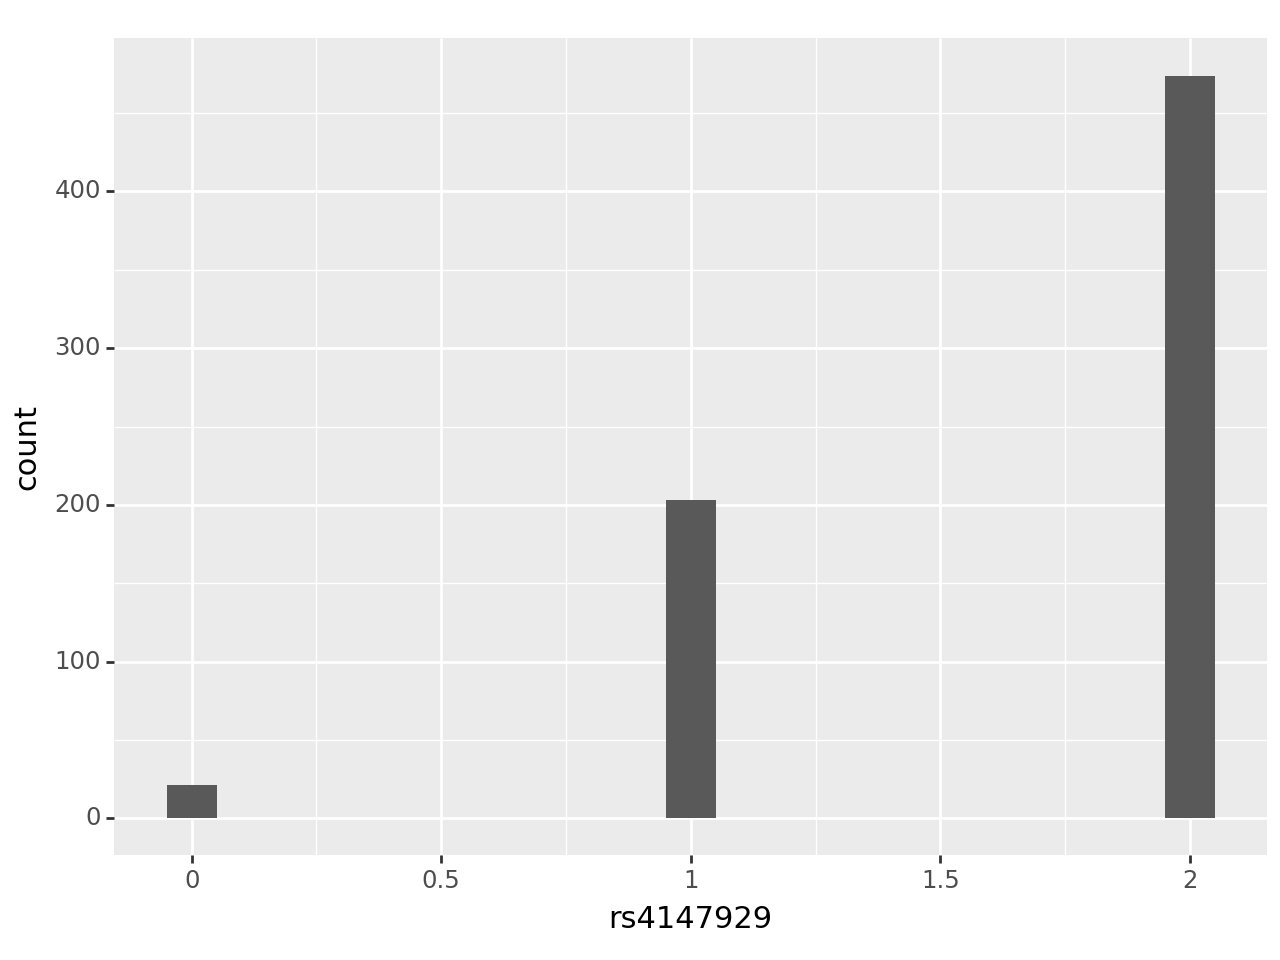

<Figure Size: (640 x 480)>

In [ ]:
# Plotting counts for location rs4147929
(ggplot(data=data) +
 aes(x='rs4147929') +
 geom_histogram(stat='bin', binwidth = 0.1) +
 labs(x = "rs4147929")
)

Now for this SNP in location **rs41289512** the Minor Allele Frequency (MAF) listed was 0.039. Notice that there are no homozygotes of the second type. We would expect $0.039^2 \ homozygotes = 0.15%$ . Out of 698 patients, we had expected just 1 patient with two times the minor allele. It is not so surprising that we don't see any.

In [ ]:
698*(0.039**2)

1.061658

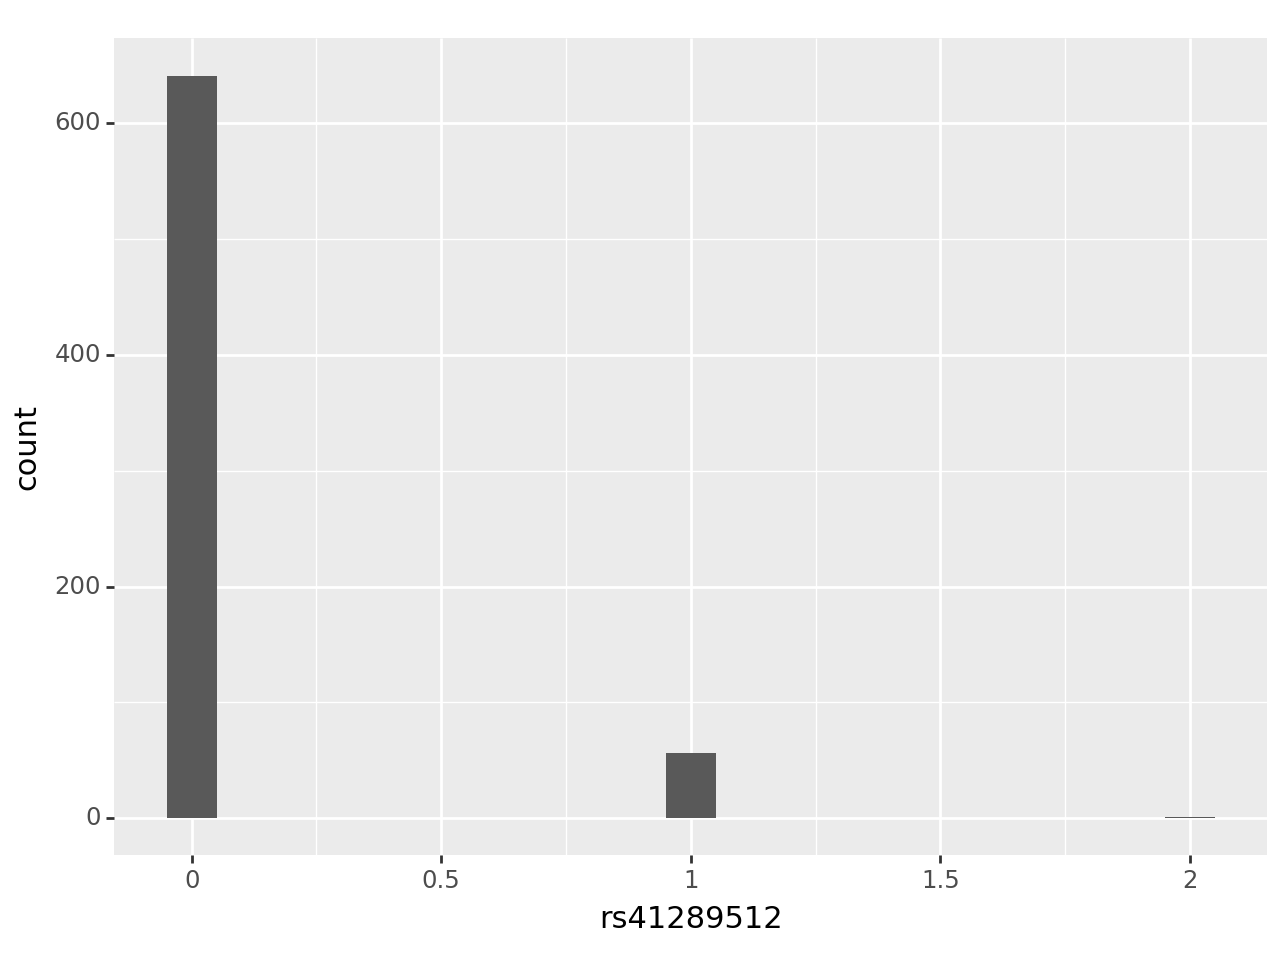

<Figure Size: (640 x 480)>

In [ ]:
# Plotting counts for location rs41289512
(ggplot(data=data) +
 aes(x='rs41289512') +
 geom_histogram(stat='bin', binwidth = 0.1) +
 labs(x = "rs41289512")
)

## Task 2: Looking at SNP genotypes.

- Plot the frequency barplots for the other two sites (**rs76320948** and **rs3865444**).
- Calculate the expected and observed number of people in the dataset with twice the minor allele for these SNPs. Is it what was expected?


In [ ]:
698*(0.046**2)

1.4769679999999998

**TASK 2 answer:**
0.046^2 * 698 = 1
We would expect 0.0462 homozygotes=0.0021 Out of 698 patients, we had expected just 1 patient with two times the minor allele

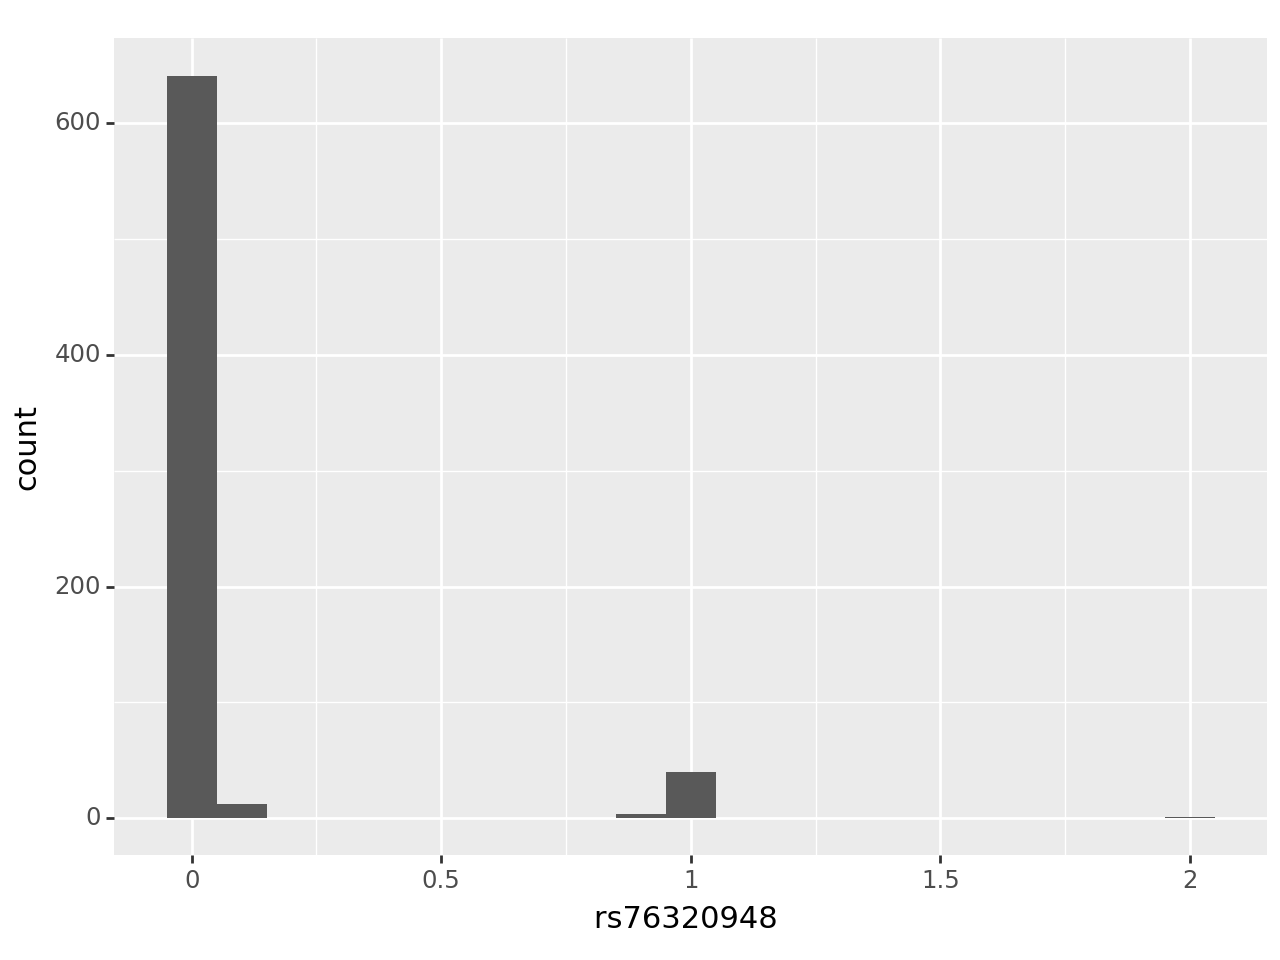

<Figure Size: (640 x 480)>

In [ ]:
# Input your code here for site rs76320948
(ggplot(data=data) +
 aes(x='rs76320948 ') +
 geom_histogram(stat='bin', binwidth = 0.1) +
 labs(x = "rs76320948 ")
)

In [ ]:
698*(0.320**2)

71.4752

0.320^2 * 698 = 71 We would expect 0.320 homozygotes=0.1024. Out of 698 patients, we had expected 71 patients with two times the minor allele

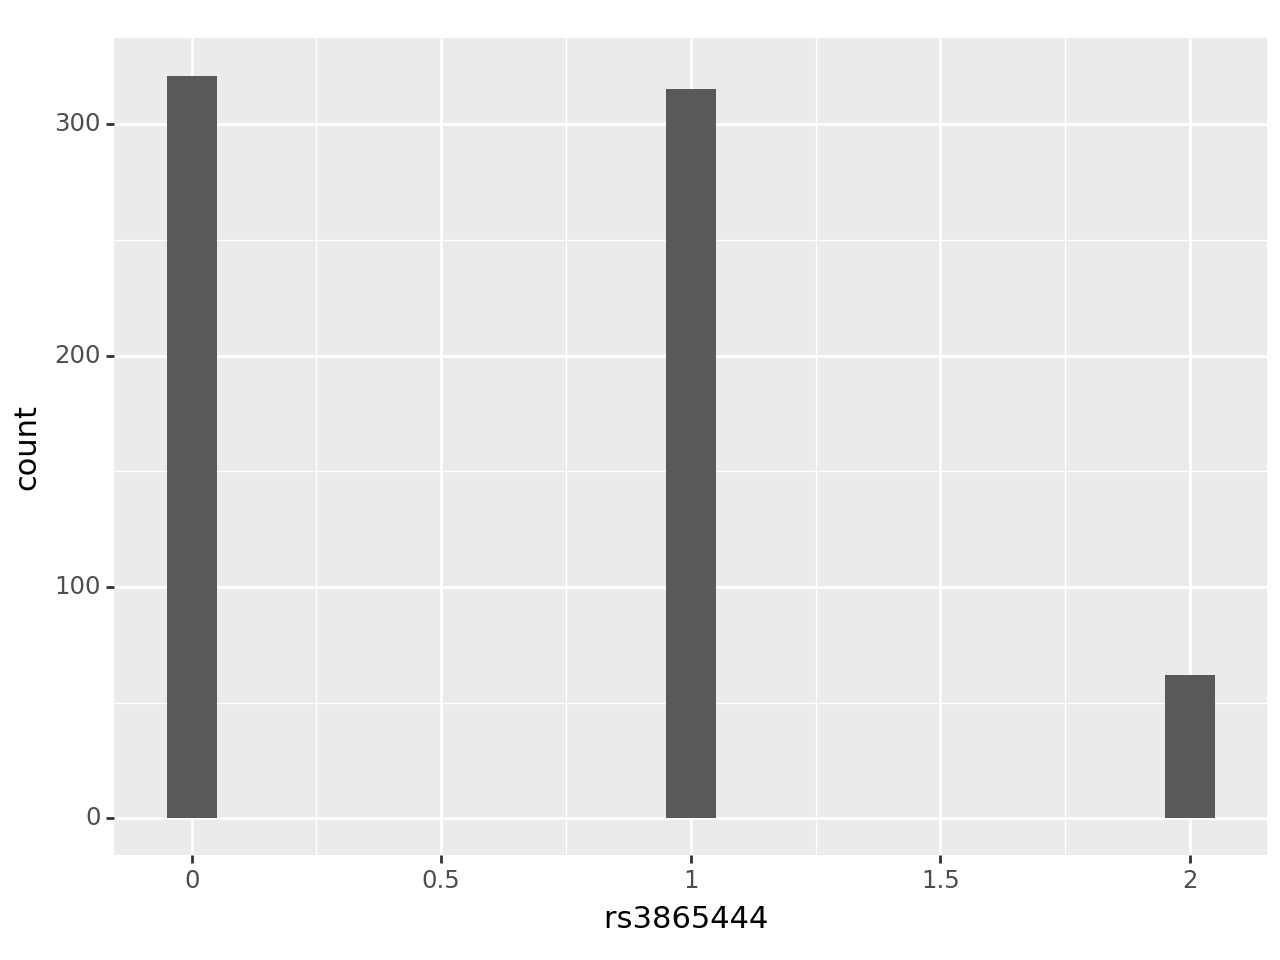

<Figure Size: (640 x 480)>

In [ ]:
# Input your code here for site rs3865444
(ggplot(data=data) +
 aes(x='rs3865444 ') +
 geom_histogram(stat='bin', binwidth = 0.1) +
 labs(x = "rs3865444 ")
)

# Random forest with genetic data for 4 SNPs

In this part we will create a Random Forest Model from this data set and valuate the model.

- Split the data in labels (the diagnosis) and features (the other columns)
- Use about 70-80% of our data as the training data and the rest as test data. In the code, 70% training and 30% test.
- Create our Randdom Fores model and training it
- Making our predictions

**NOTE:** Notice that we have set the *Random seed = 1* for splitting our data and into testing and when creating our Random Forest object. This was done for reproducibility of results

In [ ]:
# Splitting data into labels and features
labels = data["DX"]
features = data.drop(columns=['PTID','DX'])

# splitting data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=1)

# creating Random Fores Model and Training it
rf = RandomForestClassifier(n_estimators = 1000, bootstrap = True, random_state = 1)
rf.fit(features_train, labels_train)

# #Predict the response for test dataset
labels_pred = rf.predict(features_test)

Let's now take a look at what was predicted and have a sense of how we did by creating a Confusion Matrix Plot. We can also plot an accuracy score along with it.

In [ ]:
# Look at the predicted values.
print(labels_pred[:10])

['MCI' 'MCI' 'MCI' 'Dementia' 'MCI' 'Dementia' 'Dementia' 'MCI' 'MCI'
 'MCI']


Accuracy: 59.5%


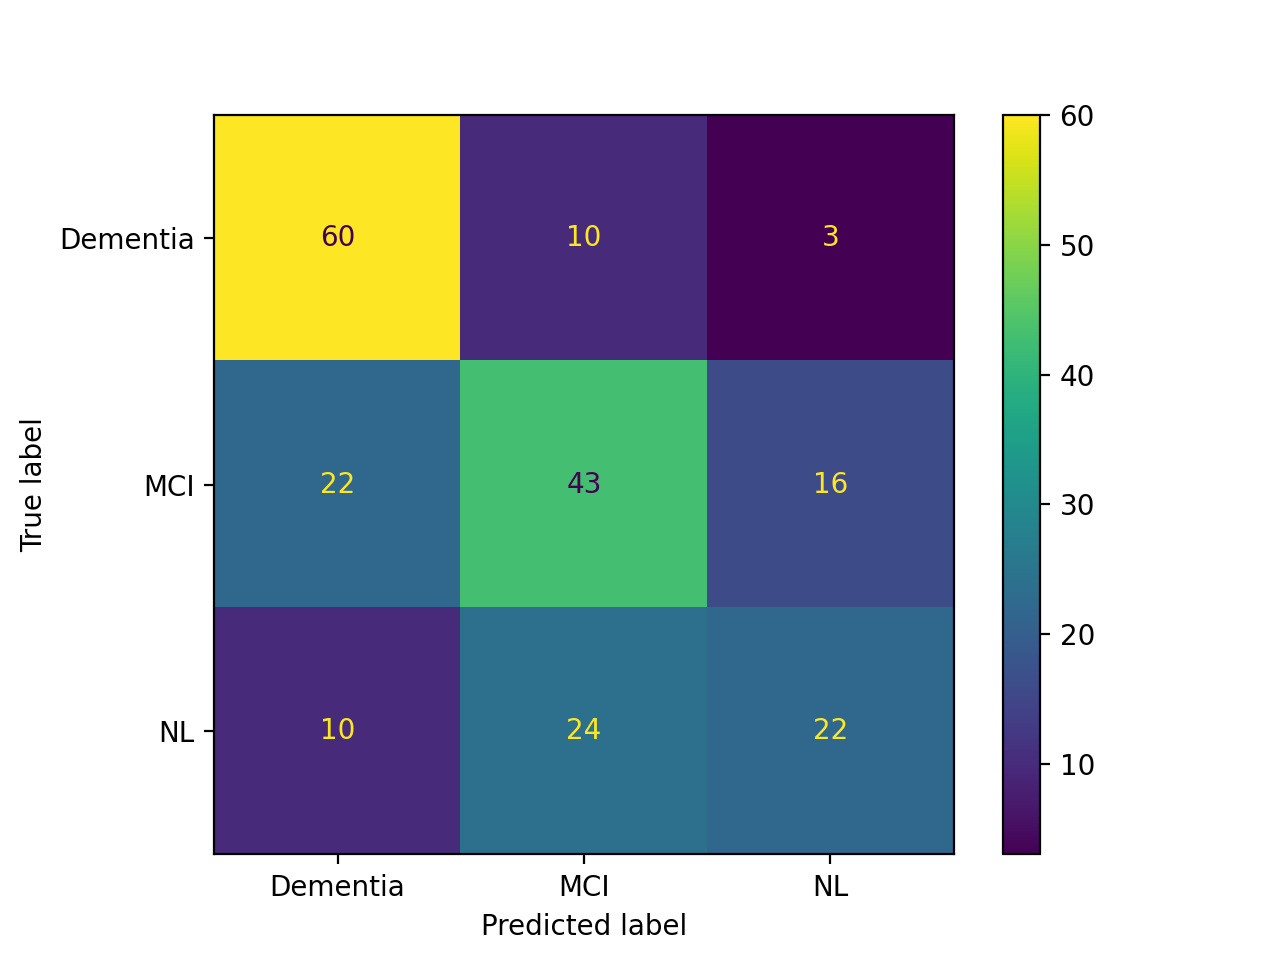

In [ ]:
#Let's visualize how well the RF does.
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.1f%%" % (accuracy * 100))
plt2 = metrics.ConfusionMatrixDisplay.from_estimator(rf, features_test, labels_test)
plt.grid(False)

We can see that our model seems to predict fairly well for people that have Alzheimer's, 13 mistakes versus 60 correct predictions. For Mild Cognitive impairment the model does not do as well with 42 correct predictions versus 39 erros and finally for Normal is doesn't do well at all since its 21 versus 35. We can actually obtain individual measures for how well a model does for a particular class using **F-scores**, more on this in later modules.


# Checking Feature Importance for our model

Below we will check the feature importance for our model. Recall that this basically shows us what features were most relevant in making predictions. Let's also visualize this to see where does SNP features rank in terms of importance for the model.

<Axes: ylabel='names'>

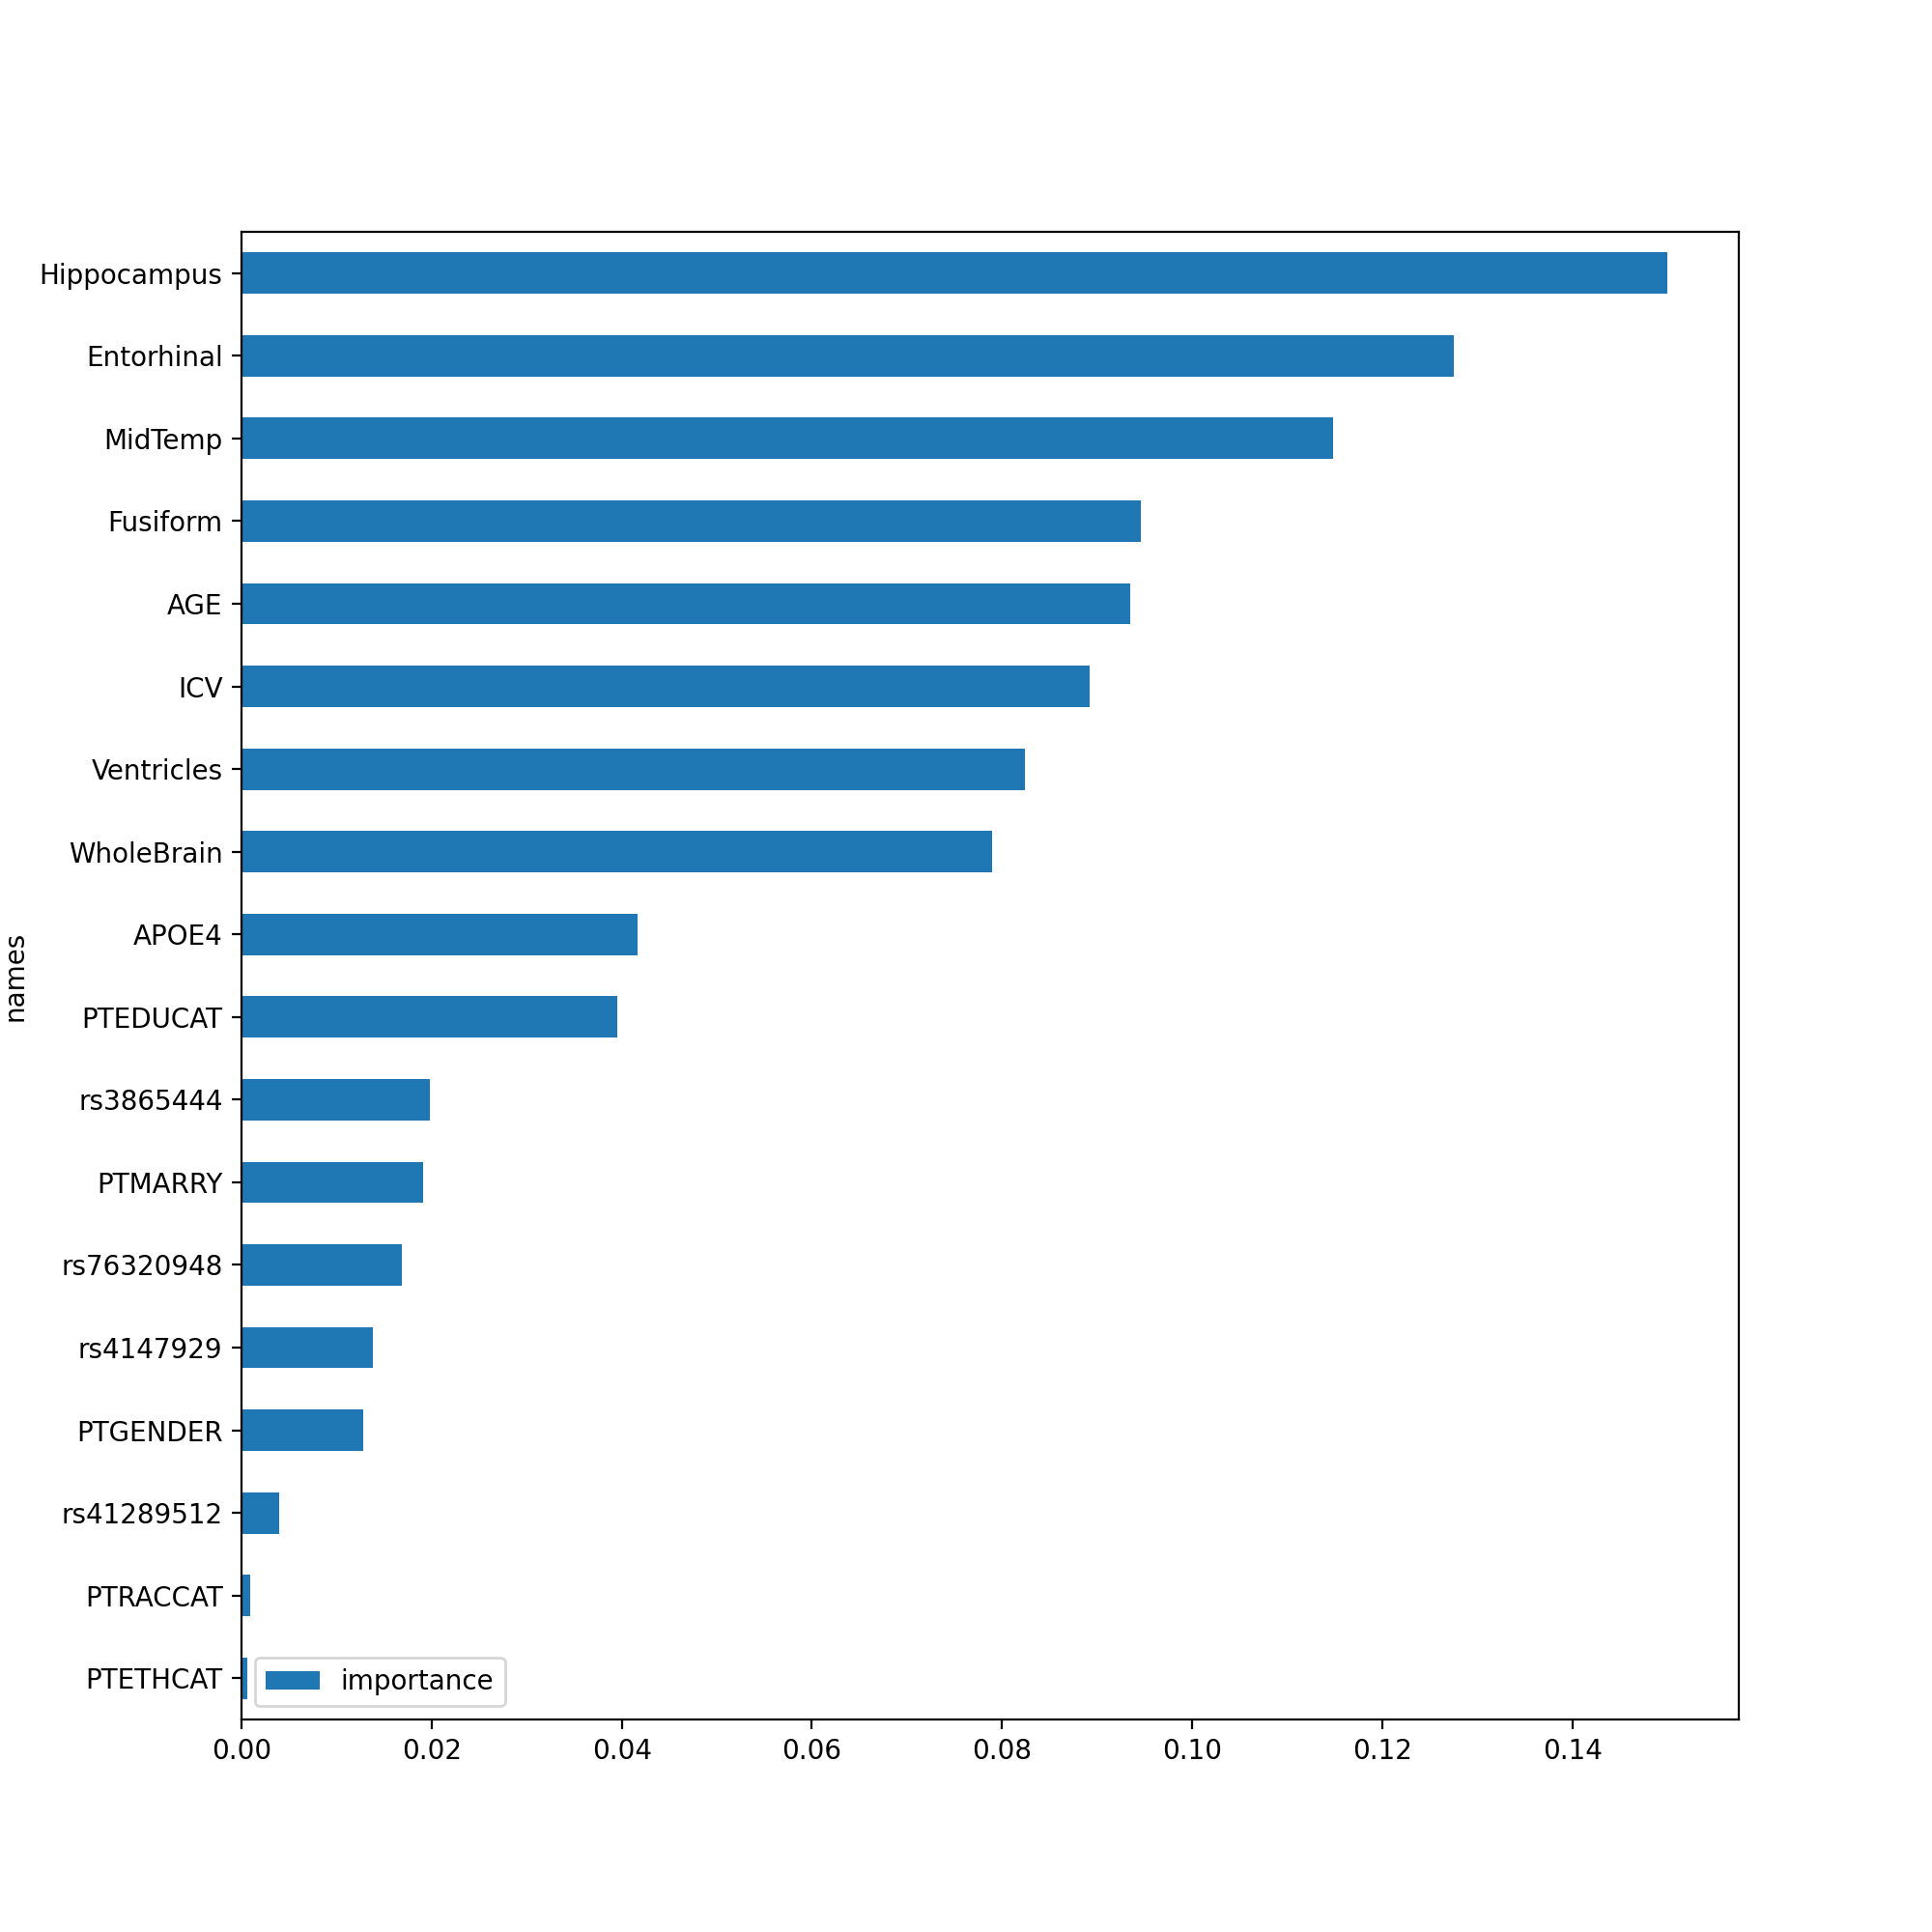

In [ ]:
# getting feature importance values from our model
importance = rf.feature_importances_

# summarize feature importance / see if the SNP columns are important for the RF
names = features.columns.to_numpy(dtype=object)

# Creating a dataframe for feature importance
importanceDF = pd.DataFrame({'names':names, 'importance':importance})

# Sort the dataframe with feature importances
importanceDF = importanceDF.sort_values(by=['importance'])

# Creating barplot for feature importance
importanceDF.plot.barh(x='names', y='importance', figsize = (10,10))

The SNP locations do not place very high in terms of aiding prediction for our model. We can see that the presence of the gene APOE4 is more relevant! The main important feature still is the hypocampus volume though by far.

So the question remains if adding genetic data actually help with the predictions at all? Below we will redo the Random Forest Model this time without the genetic data to see changes in the performance of the model and find out!

# Does Removing Genetic Data worsen the results for Random Forest Model?

In this iteration we will refit our model twice:

- First by removing the SNP location data **Model 1**

- Then by removing both SNP location data as well as the APOE4 gene feature **Model 2**

In [ ]:
# Creating  2 lists of column features one with just SNP sites and another with all genetic data
SNP_cols = ['rs4147929', 'rs41289512', 'rs76320948', 'rs3865444']
Genetics_cols = ['rs4147929', 'rs41289512', 'rs76320948', 'rs3865444', 'APOE4']

Now we will create 2 sets of features for both our models as described above. Our labels are still the same as before so we don't need to redefine them here.

In [ ]:
# Features for model 1
features_no_snp = features[features.columns.drop(SNP_cols)]

# Features for model 2
features_no_genetics = features[features.columns.drop(Genetics_cols)]

We will proceed with doing 2 different splits of training and testing data. Notice that i am keeping the random seed as 1 just to be consistent with the prior model containing all genetic features.

In [ ]:
# Split of testing and training for Model 1
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(features_no_snp, labels, test_size=0.3, random_state=1)

# Split of testing and training for Model 2
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(features_no_genetics, labels, test_size=0.3, random_state=1)

Now we will be creating 2 random forest models and train them separately. We have mantain again the same hyperparameter settings than before so we can make a fairer comparison.

In [ ]:
# Creating and training Random forest with model 1
rf1 = RandomForestClassifier(n_estimators = 1000, bootstrap = True, random_state = 1)
rf1.fit(X_train1, Y_train1)

# Creating and training Random forest with model 2
rf2 = RandomForestClassifier(n_estimators = 1000, bootstrap = True, random_state = 1)
rf2.fit(X_train2, Y_train2)

RandomForestClassifier(n_estimators=1000, random_state=1)

We will make 2 sets of predictions, one with model1 and another with model2

In [ ]:
# Predictions using model 1
Y_pred1 = rf1.predict(X_test1)

# Predictions using model 2
Y_pred2 = rf2.predict(X_test2)

Finally we will be taking a look at each models confusion matrix and accuracy scores, and what differences we get if any!

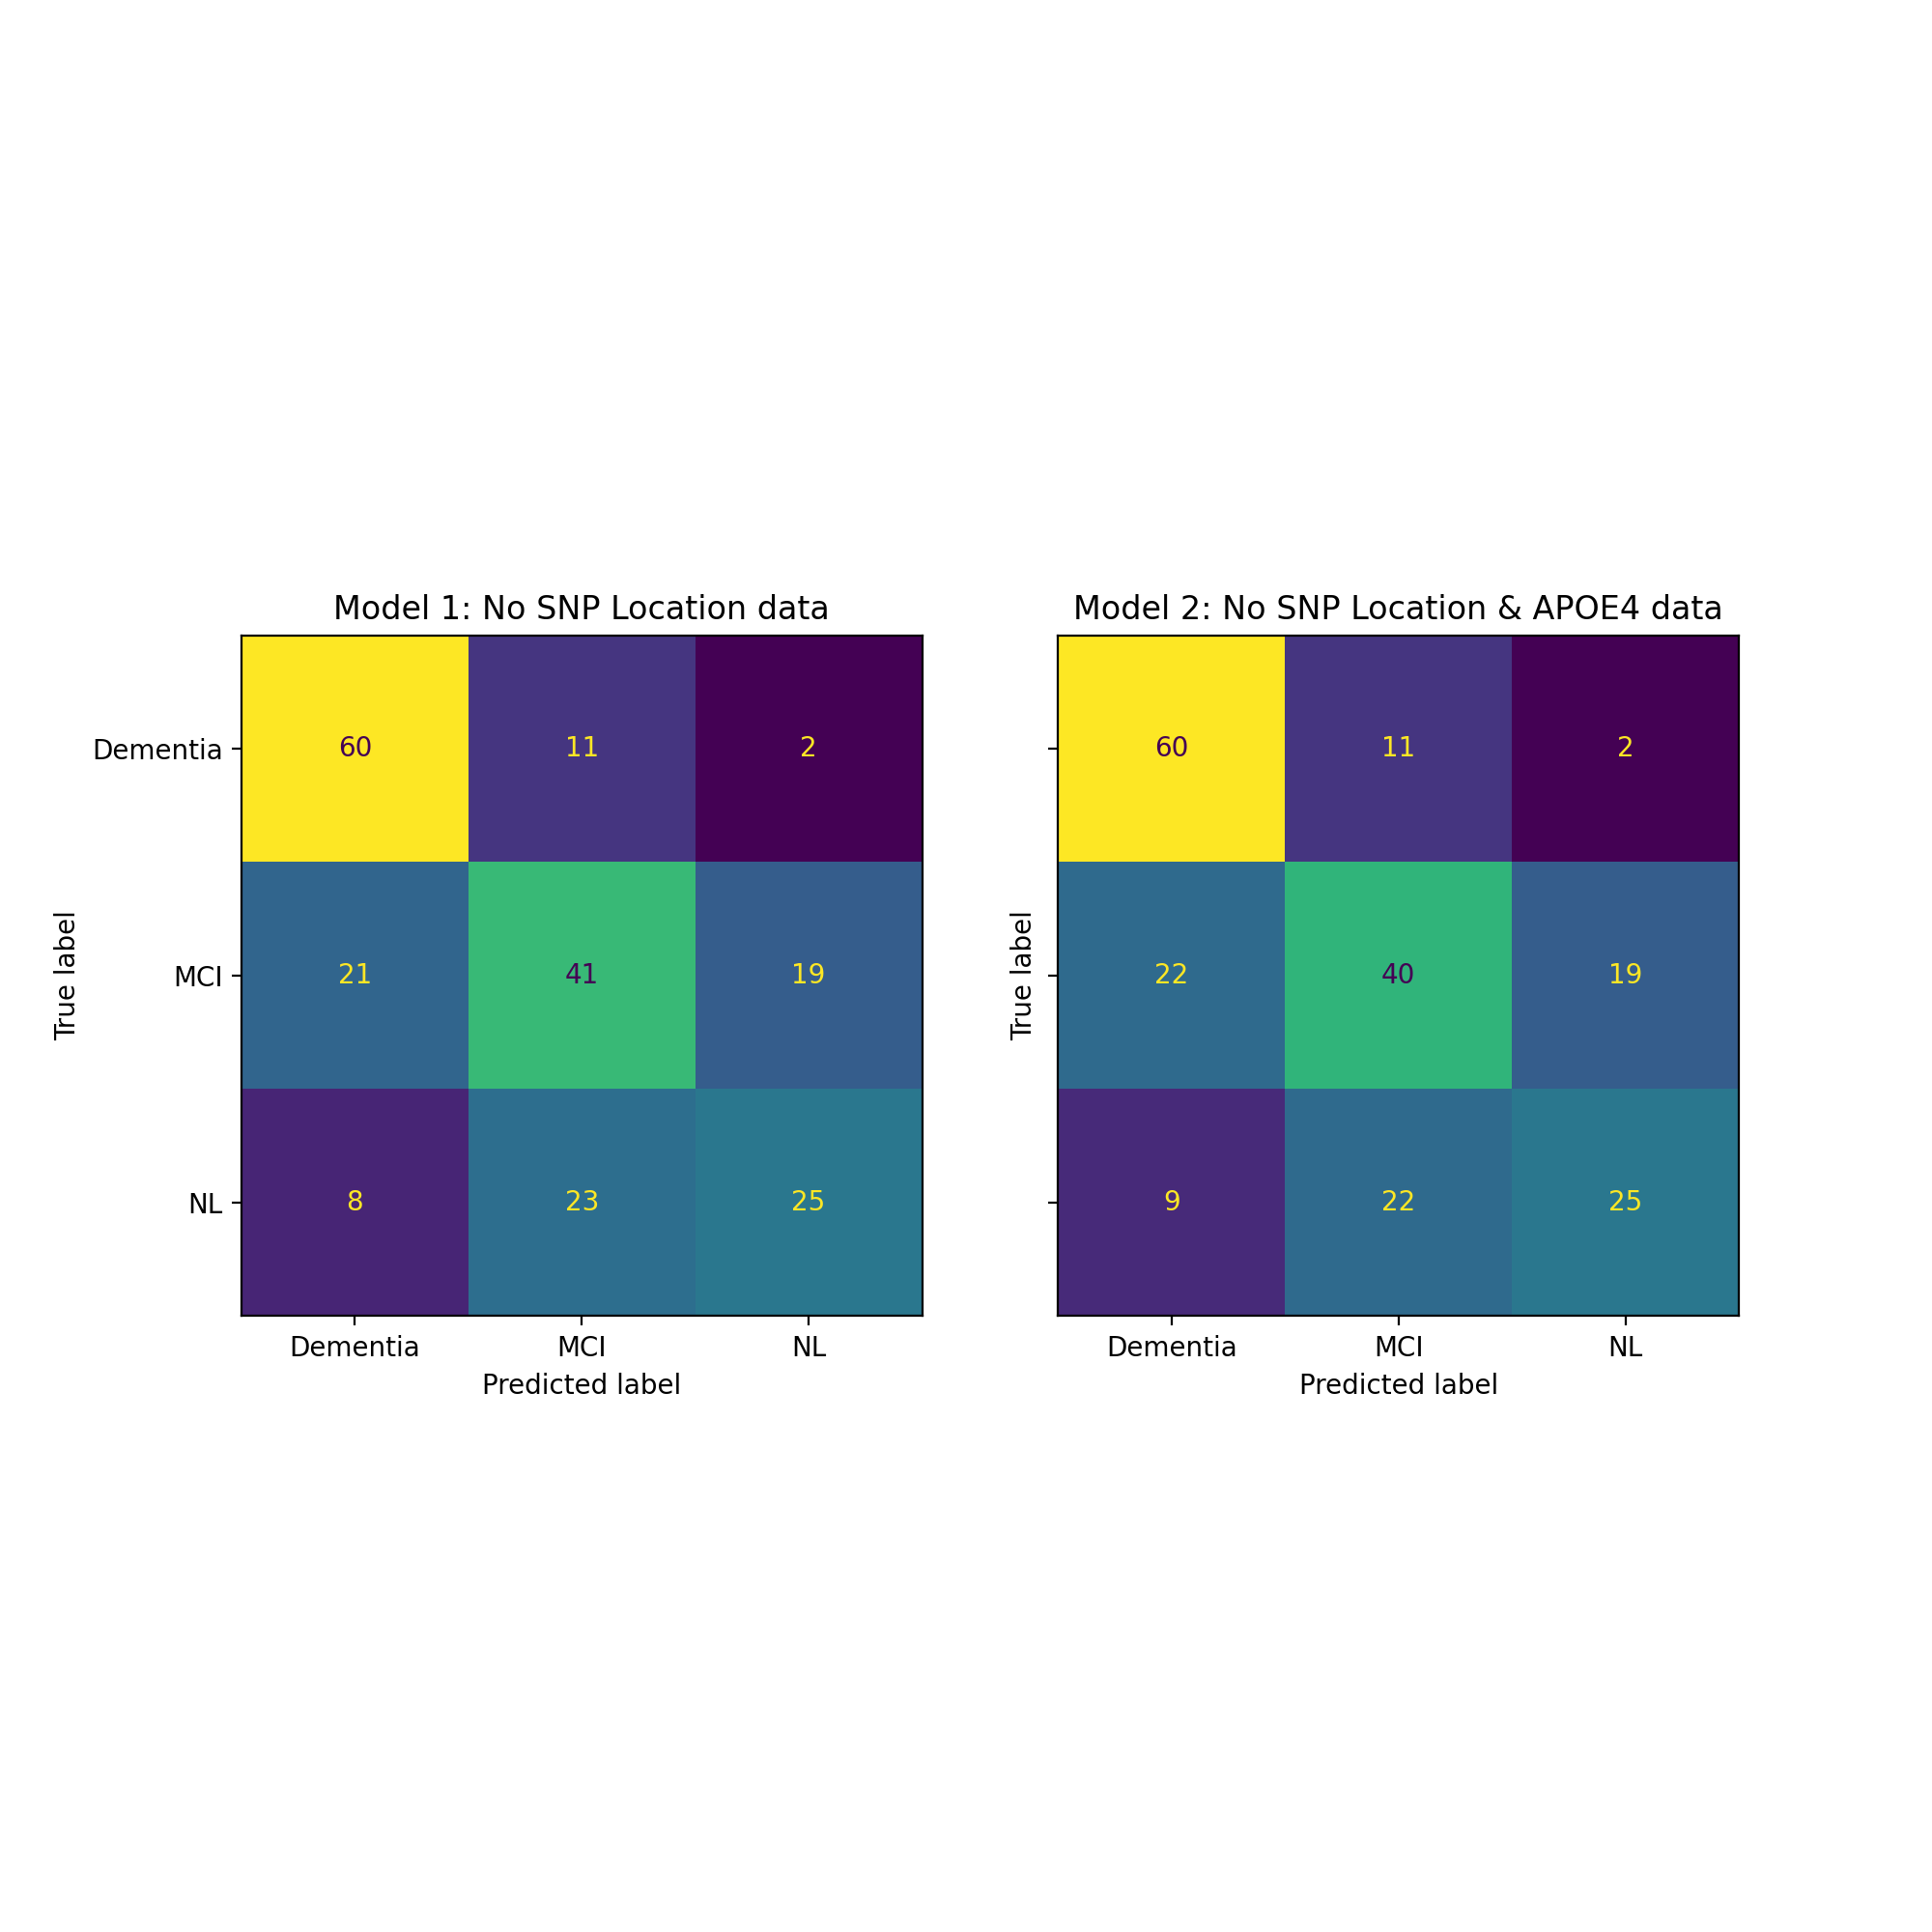

In [ ]:
# plot for model 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharey= True)
rf1_matrix = confusion_matrix(Y_test1, Y_pred1)
plt1 = ConfusionMatrixDisplay(rf1_matrix, display_labels=["Dementia","MCI","NL"])
plt1.plot(ax=ax1)
plt1.ax_.set_title("Model 1: No SNP Location data")
plt1.im_.colorbar.remove()

# plot for Model 2
rf2_matrix = confusion_matrix(Y_test2, Y_pred2)
plt2 = ConfusionMatrixDisplay(rf2_matrix, display_labels=["Dementia","MCI","NL"])
plt2.plot(ax=ax2)
plt2.ax_.set_title("Model 2: No SNP Location & APOE4 data")
plt2.im_.colorbar.remove()

plt.grid(False)


In [ ]:
# printing accuracies for both models
acc_1 = accuracy_score(Y_test1, Y_pred1)
print("Accuracy for model 1: %.1f%%" % (acc_1 * 100))
acc_2 = accuracy_score(Y_test2, Y_pred2)
print("Accuracy for model 2: %.1f%%" % (acc_2 * 100))

Accuracy for model 1: 60.0%
Accuracy for model 2: 59.5%


Looking at both of these Confusion matrices side by side, it looks like they are not that different. Model 2 does not include APOE4 and it seemed to only do a bit worse than Model 1. Surprisingly however removing the genetic information seems to have increased it's accuracy, albeit just by a minuscule amount!

# How will a Gradient Boosted Tree Model do?

Below we can quickly check the accuracies had we tried using a Gradient Boosted Model rather than a Random Forest. We will do a check of accuracies for 3 models:

- Including all the original data **Model GBT**

- First by removing the SNP location data **Model GBT1**

- Then by removing both SNP location data as well as the APOE4 gene feature **Model GBT2**

Recall that first we need to recode our labels into numbers for XGBoost modeling before we split the data. In the code below we will transform our Diagnosis Category into the values 0, 1 and 2 (Dementia, MCI and NL).

In [ ]:
# Separating labels from the general dataframe
labels = data["DX"]
# Creating a label encoder object
le = preprocessing.LabelEncoder()
# Fitting the label encoder into the labels columns
le.fit(data["DX"])
# Transforming the classes into numbers
labels_t = le.transform(data["DX"])

Splitting the Data again after **recoding the label** into numbers.

In [ ]:
# Split of testing and training for Model GBT
X_train, X_test, Y_train, Y_test = train_test_split(features, labels_t, test_size=0.3, random_state=1)

# Split of testing and training for Model GBT1
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(features_no_snp, labels_t, test_size=0.3, random_state=1)

# Split of testing and training for Model GBT2
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(features_no_genetics, labels_t, test_size=0.3, random_state=1)

Now we can quickly run **Model GBT**, **Model GBT1** and **Model GBT2** to compare accuracies.

In [ ]:
# Checking accuracy for Model GBT
GBT = XGBClassifier(random_state=1)
GBT.fit(X_train, Y_train)
Y_pred_GBT = GBT.predict(X_test)
acc_GBT = accuracy_score(Y_test, Y_pred_GBT)
print("Accuracy: %.1f%%" % (acc_GBT * 100))

Accuracy: 60.0%


In [ ]:
# Checking accuracy for Model GBT1
GBT1 = XGBClassifier()
GBT1.fit(X_train1,Y_train1)
Y_pred_GBT1 = GBT1.predict(X_test1)
acc_GBT1 = accuracy_score(Y_test1, Y_pred_GBT1)
print("Accuracy: %.1f%%" % (acc_GBT1 * 100))

Accuracy: 61.4%


In [ ]:
# Checking accuracy for Model GBT2
GBT2 = XGBClassifier()
GBT2.fit(X_train2,Y_train2)
Y_pred_GBT2 = GBT2.predict(X_test2)
acc_GBT2 = accuracy_score(Y_test2, Y_pred_GBT2)
print("Accuracy: %.1f%%" % (acc_GBT2 * 100))

Accuracy: 59.5%


Overall It seems that Gradient Boosted Trees perform better than the Random Forest one. However, it seems that for Gradient Boosted Trees, including less Genetic data seems to worsen the performance, unlike what we saw for Random Forests.

## Task 3: Hyperparameters.
1. Go back to the results of your hyper parameter tuning work. Plug in some better parameters in the models I made above. Can you make them perform better?
2. Does the genetic information about the patients help us make a better predictive model?

In [ ]:
# Checking accuracy for Model GBT
GBT = XGBClassifier(random_state=1, n_estimators=100, max_depth=10)
GBT.fit(X_train, Y_train)
Y_pred_GBT = GBT.predict(X_test)
acc_GBT = accuracy_score(Y_test, Y_pred_GBT)
print("Accuracy: %.1f%%" % (acc_GBT * 100))

Accuracy: 63.3%


In [ ]:
# Checking accuracy for Model GBT1
GBT1 = XGBClassifier()
GBT1.fit(X_train1,Y_train1)
Y_pred_GBT1 = GBT1.predict(X_test1)
acc_GBT1 = accuracy_score(Y_test1, Y_pred_GBT1)
print("Accuracy: %.1f%%" % (acc_GBT1 * 100))

Accuracy: 61.4%


In [ ]:
# Checking accuracy for Model GBT2
GBT2 = XGBClassifier()
GBT2.fit(X_train2,Y_train2)
Y_pred_GBT2 = GBT2.predict(X_test2)
acc_GBT2 = accuracy_score(Y_test2, Y_pred_GBT2)
print("Accuracy: %.1f%%" % (acc_GBT2 * 100))

Accuracy: 59.5%


1. After plugging in better hyperparameter (n_estimator and max_depth), we couldn't make it perform better.


2. No, the genetic information of patients wasn't quite helpful in making better predective model. I think we need to come up with a better hyper parameters.